# First Stage - Import data and Preprocessing the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from concurrent.futures import ProcessPoolExecutor
from google.colab import drive
import pandas as pd


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_series_path = '/data/train_series.parquet'
train_events_path = '/data/train_events.csv'
train_events_df = pd.read_csv(train_events_path)
train_events_df.head()


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [ ]:
train_series_df = pd.read_parquet(train_series_path)
train_series_df.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


# Triangle (Linear) Score Labeling

In [ ]:
def triangular_label(distance, half_window=360):
    """
    Returns a scalar in [0,1] that peaks at distance=0
    and goes to 0 at distance=half_window.

    Here, distance is measured in number of steps (each step is 5 sec).
    For a half_window of 360 steps, this corresponds to 30 minutes.
    """
    if distance > half_window:
        return 0.0
    return 1.0 - (distance / half_window)

def create_continuous_labeling(train_series_df, train_events_df, half_window=360):
    """
    Merges train_series_df with train_events_df on ['series_id','step']
    and creates a 'score' column with continuous values in [-1, 1]
    using a triangular shape over a window defined in steps.

    For each event:
      - 'onset' contributes a positive triangular shape (peak +1)
      - 'wakeup' contributes a negative triangular shape (peak -1)

    Parameters:
    -----------
    train_series_df
    train_events_df
    half_window : int, default=360
        Half of the window in steps. With 5-sec intervals, 360 steps ~ 30 minutes.
        The total window is 2 * half_window (e.g., 720 steps for 60 minutes).

    Returns:
    --------
    merged_df : DataFrame
        The input train_series_df with an additional column 'score'
        containing continuous labels in [-1, 1].
    """

    # Merge on ['series_id','step'] to align events with series data
    merged_df = train_series_df.merge(
        train_events_df[['series_id', 'step', 'event']],
        on=['series_id', 'step'],
        how='left'
    )

    # Initialize 'score' to 0 for all steps
    merged_df['score'] = 0.0

    # Create a mapping for event type -> sign (onset: +1, wakeup: -1)
    event_sign = {'onset': 1.0, 'wakeup': -1.0}

    # Group events by series_id for more efficient processing
    grouped_events = train_events_df.groupby('series_id')

    # Group the merged dataframe by series_id
    merged_grouped = merged_df.groupby('series_id', group_keys=False)

    def apply_event_labeling(group):
        """
        For each group corresponding to a single series_id, update the 'score'
        based on events for that series.
        """
        sid = group['series_id'].iloc[0]
        if sid not in grouped_events.groups:
            return group

        events_for_sid = grouped_events.get_group(sid)

        for _, evt_row in events_for_sid.iterrows():
            event_step = evt_row['step']
            evt_type = evt_row['event']
            sign = event_sign.get(evt_type, 0.0)

            # Define the window in terms of steps
            start_step = max(0, event_step - half_window)
            end_step = event_step + half_window

            # Find the rows in the group that fall within this window
            window_mask = (group['step'] >= start_step) & (group['step'] <= end_step)
            distances = np.abs(group.loc[window_mask, 'step'] - event_step)
            magnitude = 1.0 - (distances / half_window)
            magnitude = np.clip(magnitude, 0, 1)
            update_vals = sign * magnitude

            group.loc[window_mask, 'score'] += update_vals.values

        return group

    merged_df = merged_grouped.apply(apply_event_labeling)

    merged_df['score'] = np.clip(merged_df['score'], -1, 1)

    return merged_df


# Composite Score Labeling based on evaluation method

In [ ]:
import numpy as np
import pandas as pd

def composite_label(distance, tolerances=(12, 36, 60, 90, 120, 150, 180, 240, 300, 360)):
    """
    Compute a composite score for a given distance (in steps) from an event.
    For each tolerance, we assign a linear reward if within tolerance,
    and then average over all tolerances.
    """
    contributions = [(1 - distance / tol) if distance <= tol else 0.0 for tol in tolerances]
    return sum(contributions) / len(tolerances)

def create_continuous_labeling(train_series_df, train_events_df, tolerances=(12, 36, 60, 90, 120, 150, 180, 240, 300, 360)):
    """
    Merge train_series_df with train_events_df on ['series_id','step']
    and creates a 'score' column with continuous values in [-1, 1] using a composite
    labeling scheme that averages linear rewards over multiple tolerance thresholds.

    For each event:
      - 'onset' contributes a positive composite shape (peak +1)
      - 'wakeup' contributes a negative composite shape (peak -1)

    Parameters:
    -----------
    train_series_df
    train_events_df
    tolerances : tuple of int
        Tolerance thresholds in steps (each step is 5 sec). For example, (12, 36, 60, ..., 360).

    Returns:
    --------
    merged_df : DataFrame
        The input train_series_df with an additional column 'score'
        containing continuous labels in [-1, 1].
    """
    # Merge to align events with series data
    merged_df = train_series_df.merge(
        train_events_df[['series_id', 'step', 'event']],
        on=['series_id', 'step'],
        how='left'
    )
    # Initialize score to 0 for all steps
    merged_df['score'] = 0.0


    # Map event type to sign: onset positive, wakeup negative.
    event_sign = {'onset': 1.0, 'wakeup': -1.0}

    # Group events by series_id for efficiency
    grouped_events = train_events_df.groupby('series_id')
    merged_grouped = merged_df.groupby('series_id', group_keys=False)

    # Maximum window based on the largest tolerance
    max_window = max(tolerances)

    def apply_event_labeling(group):
        """
        For a given series_id group, update the 'score' based on all events for that series.
        """
        sid = group['series_id'].iloc[0]
        if sid not in grouped_events.groups:
            return group

        events_for_sid = grouped_events.get_group(sid)

        for _, evt_row in events_for_sid.iterrows():
            event_step = evt_row['step']
            evt_type = evt_row['event']
            sign = event_sign.get(evt_type, 0.0)

            # Define window based on maximum tolerance
            start_step = max(0, event_step - max_window)
            end_step = event_step + max_window

            # Identify rows in the group within the window
            window_mask = (group['step'] >= start_step) & (group['step'] <= end_step)
            steps_in_window = group.loc[window_mask, 'step']

            # Compute absolute distance from the event
            distances = np.abs(steps_in_window - event_step)
            # Compute composite score for each distance
            composite_scores = distances.apply(lambda d: composite_label(d, tolerances))
            # Update the score: if events overlap, their contributions add up.
            group.loc[window_mask, 'score'] += sign * composite_scores.values

        return group

    merged_df = merged_grouped.apply(apply_event_labeling)
    merged_df['score'] = np.clip(merged_df['score'], -1, 1)

    return merged_df



# exp decay smoothing score

In [ ]:
def create_continuous_labeling(train_series_df, train_events_df, decay_tau=2.8, smoothing_steps=180):
    """
    Merge train_series_df with train_events_df on ['series_id','step']
    and creates a 'score' column with continuous values using an exponentially
    decaying signal spread forward and backward from each event.

    For each event:
      - 'onset' contributes a positive signal (peak +1)
      - 'wakeup' contributes a negative signal (peak -1)
      - Signal is smoothed across time using exponential decay

    Parameters:
    -----------
    train_series_df
    train_events_df
    decay_tau : float
        Controls the exponential decay rate.
    smoothing_steps : int
        Number of steps forward and backward to apply smoothing over.

    Returns:
    --------
    merged_df : DataFrame
        The input train_series_df with an additional column 'score'
        containing continuous labels.
    """
    # Initialize score column
    merged_df = train_series_df.copy()
    merged_df['score'] = 0.0

    # Map event type to value: onset = +1, wakeup = -1
    event_sign = {'onset': 1.0, 'wakeup': -1.0}
    train_events_df = train_events_df.copy()
    train_events_df['event_val'] = train_events_df['event'].map(event_sign)

    # Group by series_id
    grouped_series = merged_df.groupby('series_id', group_keys=False)
    grouped_events = train_events_df.groupby('series_id')

    def apply_event_smoothing(group):
        sid = group['series_id'].iloc[0]
        group = group.sort_values('step').reset_index(drop=True)
        n = len(group)
        event_signal = np.zeros(n)

        if sid in grouped_events.groups:
            events = grouped_events.get_group(sid)
            step_to_index = {step: idx for idx, step in enumerate(group['step'])}

            for _, evt in events.iterrows():
                evt_step = evt['step']
                sign = evt['event_val']
                if evt_step not in step_to_index:
                    continue
                center_idx = step_to_index[evt_step]

                for offset in range(-smoothing_steps, smoothing_steps + 1):
                    idx = center_idx + offset
                    if 0 <= idx < n:
                        weight = np.exp(-abs(offset//12) / decay_tau)
                        event_signal[idx] += sign * weight

        group['score'] = np.clip(event_signal, -1, 1)
        return group

    merged_df = grouped_series.apply(apply_event_smoothing)
    return merged_df

In [ ]:
train_series_df = create_continuous_labeling(train_series_df, train_events_df)
train_series_df = train_series_df.rename(columns={'score': 'target'})
train_series_df

,series_id,step,timestamp,anglez,enmo,target
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217,0.0
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215,0.0
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216,0.0
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213,0.0
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215,0.0
...,...,...,...,...,...,...
592375,fe90110788d2,592375,2017-09-08T00:14:35-0400,-27.277500,0.0204,0.0
592376,fe90110788d2,592376,2017-09-08T00:14:40-0400,-27.032499,0.0233,0.0
592377,fe90110788d2,592377,2017-09-08T00:14:45-0400,-26.841200,0.0202,0.0
592378,fe90110788d2,592378,2017-09-08T00:14:50-0400,-26.723900,0.0199,0.0


# Preprocessing

In [ ]:
# Define a custom bucket: 18:00 to 18:00 the following day
def assign_bucket(timestamp):
    if timestamp.hour >= 18:
        return timestamp.date()
    else:
        return (timestamp - pd.Timedelta(days=1)).date()

def process_series_df(series_id):

  series_df = train_series_df[train_series_df['series_id'] == series_id]
  # Convert timestamp to datetime
  series_df['timestamp'] = pd.to_datetime(series_df['timestamp'], errors='coerce', utc=True)
  # Extract date, hour, and minute for grouping
  series_df['date_hour_minute'] = series_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
  series_df['hour'] = series_df['timestamp'].dt.hour
  series_df['anglez_value_counts'] = series_df['anglez'].map(series_df['anglez'].value_counts())
  # Group by minute and compute statistics
  series_minute_grouped = series_df.groupby('date_hour_minute').agg({
      'anglez': ['mean', 'std', 'median'],
      'enmo': ['mean', 'std','median'],
      'step': 'min',            # get the min step in each minute
      'hour': 'first',
      'anglez_value_counts': 'max',
      'target': lambda x: x.loc[x.abs().idxmax()]
  }).reset_index()

  # Rename columns for clarity
  series_minute_grouped.columns = ['date_hour_minute', 'anglez_mean', 'anglez_std', 'anglez_med', 'enmo_mean', 'enmo_std', 'enmo_med', 'step_min', 'hour', 'anglez_value_counts', 'target']

  series_minute_grouped['date_hour_minute'] = pd.to_datetime(series_minute_grouped['date_hour_minute'], errors='coerce')
  series_minute_grouped['bucket'] = series_minute_grouped['date_hour_minute'].apply(assign_bucket)
  return series_minute_grouped

def process(series_id):
  print(f"start processing {series_id}")
  series_minute_grouped = process_series_df(series_id)

  series_minute_grouped['bucket'] = series_minute_grouped['bucket'].astype(str)

  # Group data into buckets (dates)
  buckets = series_minute_grouped.groupby('bucket')

  # Store data for each bucket as arrays
  bucket_arrays = []

  for bucket, group in buckets:
      step = group['step_min'].to_numpy()
      target = group['target'].to_numpy()
      worn = -1 if np.all(target==0) else 1
      hour = group['hour'].to_numpy()
      enmo_values = group['enmo_mean'].to_numpy()
      enmo_std_values = group['enmo_std'].to_numpy()
      anglez_values = group['anglez_mean'].to_numpy()
      anglez_log_values = np.log1p(anglez_values + 91)  # Apply shift by 91 so the range is 1-181 and log1p transformation
      anglez_std_values = group['anglez_std'].to_numpy()
      anglez_value_counts = group['anglez_value_counts'].to_numpy()
      bucket_arrays.append({
          'series_id': series_id,
          'bucket': bucket,
          'step': step,
          'worn': worn,
          'hour': hour,
          'enmo': enmo_values,
          'enmo_std' : enmo_std_values,
          'anglez_log': anglez_log_values,
          'anglez_std' : anglez_std_values,
          'anglez_value_counts' : anglez_value_counts,
          'target': target
      })
  print(f"finished processing {series_id}")
  return bucket_arrays

In [ ]:
# processing all series id to buckets
series_ids = train_events_df['series_id'].unique()
with ProcessPoolExecutor() as executor:
    results = list(executor.map(process, series_ids))

flat_data = []
for result in results:
    for bucket in result:
        flat_data.append({
            "series_id": bucket['series_id'],
            "bucket": bucket['bucket'],
            "step": bucket['step'],
            "worn": bucket['worn'],
            "hour": bucket['hour'],
            "enmo": list(bucket['enmo']),
            "enmo_std": list(bucket['enmo_std']),
            "anglez_log": list(bucket['anglez_log']),
            "anglez_std": list(bucket['anglez_std']),
            "anglez_value_counts": list(bucket['anglez_value_counts']),
            "target": list(bucket['target'])
        })

buckets = pd.DataFrame(flat_data)

TARGET_LENGTH = 1440

def pad_to_length_edge(array, target_length=1440):
    pad_length = target_length - len(array)
    if pad_length > 0:
        return np.pad(array, (0, pad_length), mode='edge')
    return array

# Apply padding to each feature column
for col in ['step', 'enmo', 'hour', 'enmo_std', 'anglez_log', 'anglez_std', 'anglez_value_counts', 'target']:
    buckets[col] = buckets[col].apply(lambda x: pad_to_length_edge(x, 1440))
buckets.to_parquet("buckets.parquet", index=False)

adding ewma to anglez_log and enmo, and standardize the data by each day


In [ ]:
buckets = pd.read_parquet("buckets.parquet")
buckets['anglez_log_ewma'] = buckets['anglez_log'].apply(lambda x: pd.Series(x).ewm(span=30).mean().to_numpy())
buckets['enmo_ewma'] = buckets['enmo'].apply(lambda x: pd.Series(x).ewm(span=30).mean().to_numpy())
for col_name in ['enmo', 'enmo_std', 'anglez_log', 'anglez_std', 'anglez_log_ewma', 'enmo_ewma']:
  buckets[col_name] = buckets[col_name].apply(lambda arr: (arr - np.mean(arr)) / np.std(arr) if np.std(arr) != 0 else arr)
buckets.to_parquet("processed_data/buckets_for_worn_unworn_model.parquet", index=False)
buckets

,series_id,bucket,step,worn,hour,enmo,enmo_std,anglez_log,anglez_std,anglez_value_counts,target,anglez_log_ewma,enmo_ewma
0,038441c925bb,2018-08-14,"[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, ...",1,"[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1...","[-0.16349883, -0.1931289, -0.25024912, -0.3244...","[-0.4392864, -0.27086866, -0.08205997, -0.4434...","[0.6985727, 1.0362152, -0.3485857, -2.2371774,...","[-0.70323086, 1.7682015, 3.7148108, -0.7146914...","[4, 5, 3, 3, 2, 1, 2, 2, 2, 1, 2, 2, 2, 8, 7, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.87253032818905, 1.0891742536778797, 0.54940...","[-0.26692548136100913, -0.2915036204859992, -0..."
1,038441c925bb,2018-08-15,"[16200, 16212, 16224, 16236, 16248, 16260, 162...",1,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[-0.5445473, -0.5384195, -0.55367094, 2.207655...","[-0.3984071, -0.43412158, -0.40988225, 2.16966...","[-1.1600173, -1.0104151, -1.0199851, 0.0843932...","[-0.7463166, -0.8548056, -0.8091363, 0.5429577...","[3, 2, 2, 6, 2, 4, 2, 1, 3, 1, 1, 3, 2, 2, 9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.9347463538710923, -1.8052268870075403, -1....","[-0.8166037670768754, -0.8118206280960815, -0...."
2,038441c925bb,2018-08-16,"[33480, 33492, 33504, 33516, 33528, 33540, 335...",1,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[0.23109697, 0.09120488, 0.033813287, 0.026639...","[-0.20623524, -0.11359837, -0.052542243, -0.14...","[-0.008634078, 0.08142903, 0.30459088, 0.27667...","[1.3266863, 1.6417787, 1.327748, 1.3931719, 2....","[5, 2, 2, 2, 2, 1, 2, 10, 6, 2, 2, 5, 7, 2, 1,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.012038710129515684, 0.0613677671531428, 0....","[0.4748477605776372, 0.3245841466999011, 0.232..."
3,038441c925bb,2018-08-17,"[50760, 50772, 50784, 50796, 50808, 50820, 508...",1,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[-0.2527756, 1.1799846, 1.5040432, 5.1157236, ...","[0.28345567, 1.0553511, 1.8320727, 4.9168553, ...","[0.15004267, 0.43735644, 0.38528717, 0.5604871...","[-0.24063708, -0.0013753887, 0.13565959, 0.492...","[4, 5, 2, 1, 5, 6, 1, 5, 2, 2, 2, 2, 2, 2, 2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.22597487040083097, 0.4316607742666523, 0.47...","[-0.4886070050651297, 0.9160947103060656, 1.60..."
4,038441c925bb,2018-08-18,"[68040, 68052, 68064, 68076, 68088, 68100, 681...",-1,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[0.6479936, 0.8932235, 2.833645, 0.38491568, -...","[0.572238, 1.5555285, 0.8140591, 0.75956106, -...","[1.5341367, 1.3622736, 1.2962915, -0.18275754,...","[4.216422, 5.2023964, 4.2594304, 11.148555, -0...","[1, 3, 2, 1, 1, 3, 1, 2, 3, 2, 2, 3, 2, 5, 2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.996684334602296, 2.8238807476625687, 2.7206...","[0.7927296714407751, 0.9473498559096987, 1.841..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7663,fe90110788d2,2017-09-03,"[515880, 515892, 515904, 515916, 515928, 51594...",1,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[-0.39168963, 0.02547008, -0.21197024, 0.09981...","[-0.32646853, -0.17424636, -0.2246426, 0.05075...","[0.8239082, 0.7366087, 0.5501097, 0.91960484, ...","[-0.7439602, 0.40150043, 0.6085535, 1.701254, ...","[2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 4, 3, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9683353925295484, 0.9151247348357161, 0.819...","[-0.6312028539221515, -0.28394551386104594, -0..."
7664,fe90110788d2,2017-09-04,"[533160, 533172, 533184, 533196, 533208, 53322...",1,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[-0.44145885, -0.21067801, -0.30475134, -0.294...","[-0.44973117, -0.16417368, -0.32016867, -0.351...","[0.4511651, 0.60762316, 0.5020324, 0.648447, 0...","[-0.23191503, -0.27928302, -0.19890119, 0.1397...","[3, 3, 3, 2, 2, 3, 2, 4, 3, 2, 2, 3, 2, 2, 2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5825377068897355, 0.6872550044267914, 0.673...","[-0.6145727612055494, -0.44889

filtering unworn buckets for picks prediction model

In [ ]:
filtered_buckets = buckets[buckets['worn'] != -1]
filtered_buckets.to_parquet("processed_data/buckets_for_picks_prediction_model.parquet", index=False)


'/content/drive/My Drive/WorkshopML/processed data/buckets_for_worn_unworn_model_5.4.parquet'

another preprocess made in WorkshopML_training_score_predict_models notebook:
*   sliding windows of std, mad
*   replace hour with hour_sin, hour_cos



# process first series id to check the process function


In [ ]:
series_ids = train_events_df['series_id'].unique()
result = process(series_ids[0])
flat_data = []
for bucket in result:
        flat_data.append({
            "series_id": bucket['series_id'],
            "bucket": bucket['bucket'],
            "step": bucket['step'],
            "worn": bucket['worn'],
            "hour": bucket['hour'],
            "enmo": list(bucket['enmo']),
            "enmo_std": list(bucket['enmo_std']),
            "anglez_log": list(bucket['anglez_log']),
            "anglez_std": list(bucket['anglez_std']),
            "anglez_value_counts": list(bucket['anglez_value_counts']),
            "target": list(bucket['target'])
        })
sample_series = pd.DataFrame(flat_data)
sample_series
print(sample_series['target'].iloc[1])

start processing 038441c925bb


<ipython-input-9-be227355a60f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_df['timestamp'] = pd.to_datetime(series_df['timestamp'], errors='coerce', utc=True)
<ipython-input-9-be227355a60f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_df['date_hour_minute'] = series_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
<ipython-input-9-be227355a60f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

finished processing 038441c925bb
[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0

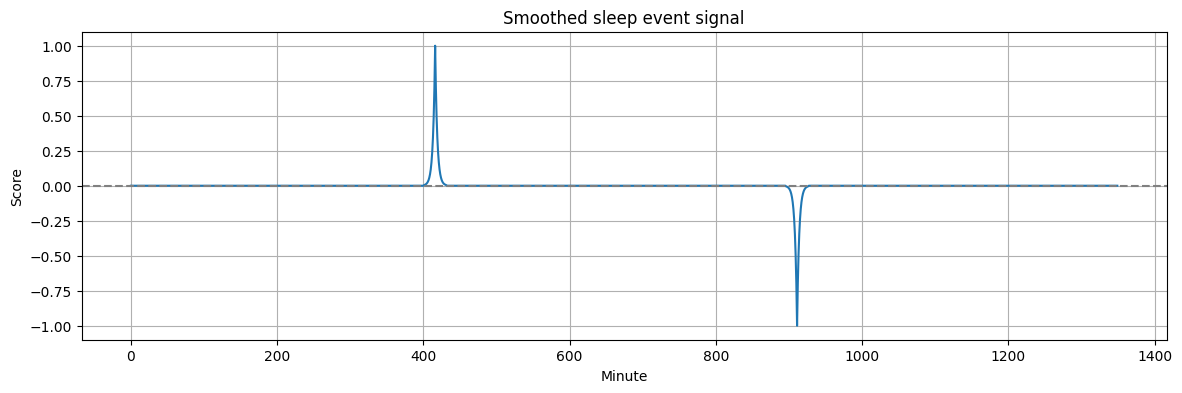

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.plot(sample_series['target'].iloc[0])
plt.axhline(0, color="gray", linestyle="--")
plt.title("Smoothed sleep event signal")
plt.xlabel("Minute")
plt.ylabel("Score")
plt.grid(True)
plt.show()

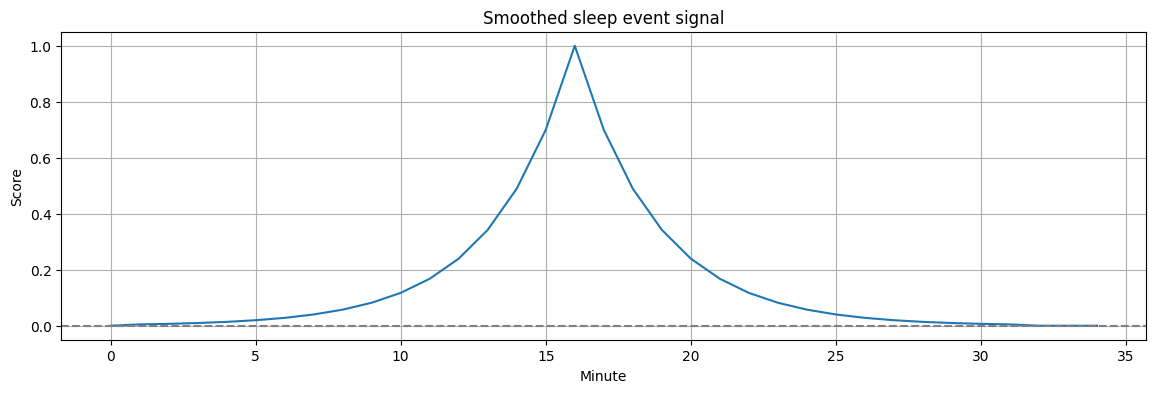

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.plot(sample_series['target'].iloc[0][400:435])
plt.axhline(0, color="gray", linestyle="--")
plt.title("Smoothed sleep event signal")
plt.xlabel("Minute")
plt.ylabel("Score")
plt.grid(True)
plt.show()